## 신용카드 사용자 연체 예측 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import matplotlib

In [2]:
card_train = pd.read_csv('train.csv')
card_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
#name이 이미 처리되어있어서 따로 설정해줄 필요 없음을 확인

card_train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


* index  
* gender: 성별  
* car: 차량 소유 여부  
* reality: 부동산 소유 여부  
* child_num: 자녀 수  
* income_total: 연간 소득  
* income_type: 소득 분류  
* edu_type: 교육 수준  
* family_type: 결혼 여부  
* house_type: 생활 방식  
* DAYS_BIRTH: 출생일  
* DAYS_EMPLOYED: 업무 시작일  
* FLAG_MOBIL: 핸드폰 소유 여부  
* work_phone: 업무용 전화 소유 여부  
* phone: 전화 소유 여부  
* email: 이메일 소유 여부  
* occyp_type: 직업 유형  													
* family_size: 가족 규모  
* begin_month: 신용카드 발급 월  
* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도  

출처 : https://dacon.io/competitions/official/235713/talkboard/402821?page=1&dtype=recent

In [6]:
#디테일하게 데이터 보고자 출력
card_train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


<AxesSubplot:>

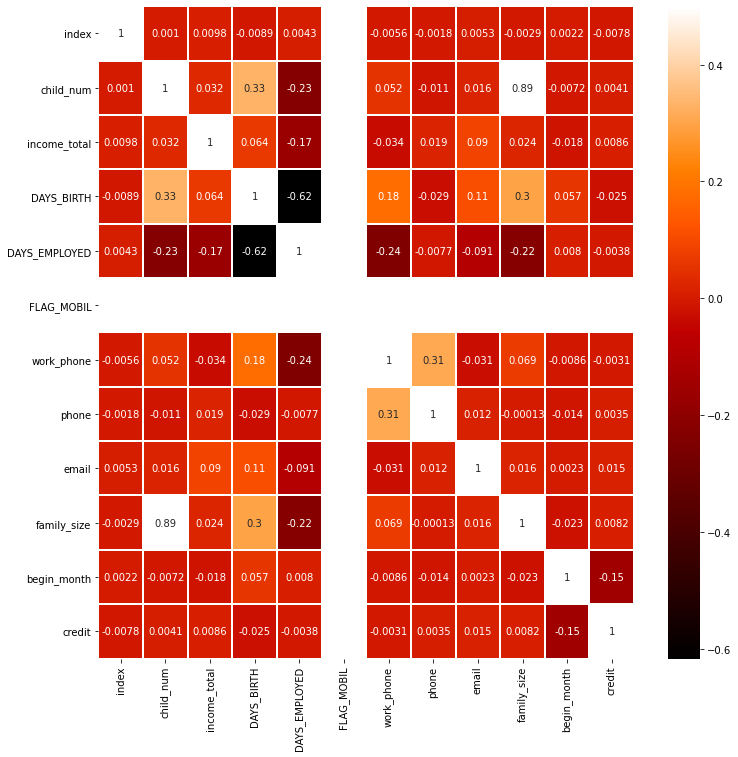

In [7]:
# credit 과 상관관계가 높은 변수를 보고자 히트맵을 그려보았는데 높은 상관관계를 보여주는 것은 뚜렷하게 없어보임

import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(card_train.corr(), linewidths=0.1, vmax=0.5, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)

In [8]:
card_train['credit'].value_counts()

#신용도는 0,1,2 로 분류되며 낮을수록 높은 신용의 신용카드 사용자임 -> 0이 신용도가 낮은 사람으로 연체 가능성이 있다고 판단

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

In [9]:
#전체적으로 보기엔 정리가 안되보임 -> 문자열 위주로 다시 출력

card_train.value_counts()

index  gender  car  reality  child_num  income_total  income_type           edu_type                       family_type           house_type           DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  occyp_type      family_size  begin_month  credit
1      F       N    Y        1          247500.0      Commercial associate  Secondary / secondary special  Civil marriage        House / apartment    -11380      -1540          1           0           0      1      Laborers        3.0          -5.0         1.0       1
17636  F       N    Y        2          81000.0       Working               Secondary / secondary special  Married               House / apartment    -13333      -109           1           0           0      0      Laborers        4.0          -8.0         1.0       1
17644  F       Y    Y        1          180000.0      Working               Higher education               Married               House / apartment    -15001      -249           1           0        

In [10]:
#각 속성이 어떻게 이루어졌는지 파악이 가능함 ->문자열의 경우 같은 뜻이지만 다르게 기술하여 놓치는 부분이 생길수도 있음

for target in ['gender','car','reality','income_type','edu_type','family_type','house_type','occyp_type']:
                shape = card_train[target].value_counts()
                print(shape)

F    17697
M     8760
Name: gender, dtype: int64
N    16410
Y    10047
Name: car, dtype: int64
Y    17830
N     8627
Name: reality, dtype: int64
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64
Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64
Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64
House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64
Laborers                 4512
Core staff               2646
Sa

In [11]:
#데이터 가공에 앞서서 범주형인지 연속형인지 파악해야함 -> 아래의 코드로 대략적인 파악이 가능함

unique_len = card_train.apply(lambda x : len(x.unique()))
unique_len

index            26457
gender               2
car                  2
reality              2
child_num            9
income_total       249
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        6621
DAYS_EMPLOYED     3470
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          19
family_size         10
begin_month         61
credit               3
dtype: int64

In [12]:
#isnull()함수 사용하여 데이터에 whitespace가 있는지 확인해봄 
#앞에서도 볼 수 있었지만 이 함수를 보면 정확하게 나옴 -> occyp_type 에 null 값이 8171개

card_train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [13]:
#occyp_type 을 drop 하고 다시 데이터셋 정렬, index도 불필요하다 생각하여 drop
#"FLAG_MOBIL" 값은 전부 1이므로 변수가 되지 않을 것 같아 drop
#index의 경우 데이터 학습에 영향을 미칠 요소는 아닌 것 같아 drop
dr_train = card_train.drop(["occyp_type","FLAG_MOBIL","index"], axis=1)
dr_test = card_test.drop(["occyp_type","FLAG_MOBIL","index"], axis=1)

In [14]:
#정상적으로 drop됨을 확인

dr_train.isnull().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
work_phone       0
phone            0
email            0
family_size      0
begin_month      0
credit           0
dtype: int64

In [15]:
dr_test.isnull().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
work_phone       0
phone            0
email            0
family_size      0
begin_month      0
dtype: int64

In [16]:
#get_dummies()함수는 문자열과 범주형 데이터에만 사용가능하다 ->연속형 데이터는 제외
#drop_first=True 옵션으로 가변수의 첫번째 변수를 자동 삭제하여 가변수 함정(dummy trap) 방지
#연속형 데이터를 전처리과정에서 범주형과 문자형으로 변형해주어 모든 변수 get_dummies()함수 사용

print("학습 데이터 원본 특성:\n", list(dr_train.columns), "\n")
dr_train = pd.get_dummies(dr_train, drop_first=True)
print("get_dummies 후의 특성:\n", list(dr_train.columns))

print("---------------------------------------------------------")

print("테스트 데이터 원본 특성:\n", list(dr_test.columns), "\n")
dr_test = pd.get_dummies(dr_test, drop_first=True)
print("get_dummies 후의 특성:\n", list(dr_test.columns))

학습 데이터 원본 특성:
 ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit'] 

get_dummies 후의 특성:
 ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit', 'gender_M', 'car_Y', 'reality_Y', 'income_type_Pensioner', 'income_type_State servant', 'income_type_Student', 'income_type_Working', 'edu_type_Higher education', 'edu_type_Incomplete higher', 'edu_type_Lower secondary', 'edu_type_Secondary / secondary special', 'family_type_Married', 'family_type_Separated', 'family_type_Single / not married', 'family_type_Widow', 'house_type_House / apartment', 'house_type_Municipal apartment', 'house_type_Office apartment', 'house_type_Rented apartment', 'house_type_With parents']
---------------------------------------------------------
테스트 데이터 원본 특성:
 ['gender', 'car'

<AxesSubplot:>

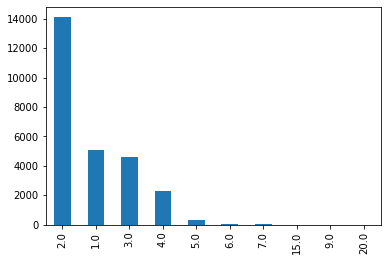

In [17]:
dr_train['family_size'].value_counts().plot.bar()

In [18]:
dr_train.loc[dr_train['family_size'] >4, 'family_size'] = 4

<AxesSubplot:>

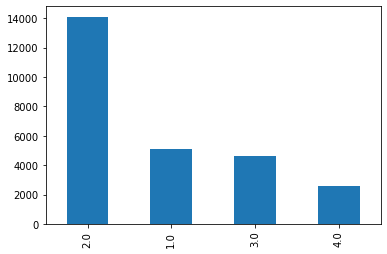

In [19]:
dr_train['family_size'].value_counts().plot.bar()

<AxesSubplot:>

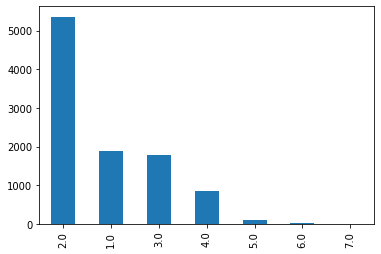

In [20]:
dr_test['family_size'].value_counts().plot.bar()

In [21]:
dr_test.loc[dr_test['family_size'] >4, 'family_size'] = 4

<AxesSubplot:>

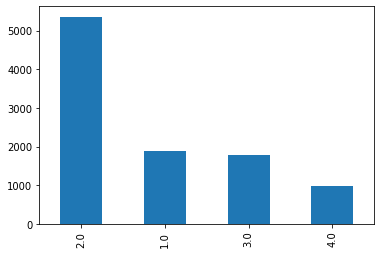

In [22]:
dr_test['family_size'].value_counts().plot.bar()

In [23]:
#'family_size'변수는 숫자 특성으로 인식되어 get_dummies()가 적용이 안되어, 문자열 특성으로 적용해준 후 다시 get_dummies()로 가변수 생성

#dr_train['family_size'] = dr_train['family_size'].astype(str)
#dr_test['family_size'] = dr_test['family_size'].astype(str)

In [24]:
#dr_train['credit'] = dr_train['credit'].astype(str)

이제 데이터 전처리 해줘야 하는 남은 변수는 'income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month'

In [25]:
dr_train[['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month']].head(10)

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,begin_month
0,202500.0,-13899,-4709,-6.0
1,247500.0,-11380,-1540,-5.0
2,450000.0,-19087,-4434,-22.0
3,202500.0,-15088,-2092,-37.0
4,157500.0,-15037,-2105,-26.0
5,270000.0,-13413,-4996,-18.0
6,315000.0,-17570,-1978,-41.0
7,270000.0,-14896,-5420,-53.0
8,180000.0,-15131,-1466,-38.0
9,103500.0,-15785,-1308,-5.0


In [26]:
#'income_total'은 249개의 unique가 있다는 것을 알 수 있음
dr_train['income_total'].value_counts()

135000.0    3164
157500.0    2233
180000.0    2225
112500.0    2178
225000.0    2170
            ... 
227250.0       1
91530.0        1
39600.0        1
432000.0       1
215100.0       1
Name: income_total, Length: 249, dtype: int64

In [27]:
#임의적으로 7개로 데이터 분할
counts, bin_dividers = np.histogram(dr_train['income_total'], bins =7)

In [28]:
#7개로 분할됨을 알 수 있음 -> 구간의 시작점을 포함하기 위해 include_lowest=True 사용
pd.cut(dr_train['income_total'], bins = bin_dividers, include_lowest = True)

0         (26999.999, 248142.857]
1         (26999.999, 248142.857]
2        (248142.857, 469285.714]
3         (26999.999, 248142.857]
4         (26999.999, 248142.857]
                   ...           
26452     (26999.999, 248142.857]
26453     (26999.999, 248142.857]
26454    (248142.857, 469285.714]
26455     (26999.999, 248142.857]
26456     (26999.999, 248142.857]
Name: income_total, Length: 26457, dtype: category
Categories (7, interval[float64]): [(26999.999, 248142.857] < (248142.857, 469285.714] < (469285.714, 690428.571] < (690428.571, 911571.429] < (911571.429, 1132714.286] < (1132714.286, 1353857.143] < (1353857.143, 1575000.0]]

In [29]:
#연속형 데이터가 범주형 데이터로 인코딩 되었음을 확인 가능

#이 부분을 다시 dr_train의 변수로 적용해줄 것이기에 dr_train으로 변경함
dr_train['income_total']=pd.cut(dr_train['income_total'], bins = bin_dividers, include_lowest = True, labels = np.arange(7))
dr_test['income_total']=pd.cut(dr_test['income_total'], bins = bin_dividers, include_lowest = True, labels = np.arange(7))

**'DAYS_BIRTH','DAYS_EMPLOYED','begin_month' 이 변수들은 값이 음수이기에 양수로 바꿔주고 그 다음에 범주형으로 인코딩**

In [30]:
dr_train['DAYS_BIRTH'].value_counts()

-12676    40
-15519    38
-14667    32
-15140    26
-16768    24
          ..
-23117     1
-21070     1
-11175     1
-15269     1
-19490     1
Name: DAYS_BIRTH, Length: 6621, dtype: int64

In [31]:
dr_train['DAYS_BIRTH'] = -dr_train['DAYS_BIRTH'] / 365
dr_test['DAYS_BIRTH'] = -dr_test['DAYS_BIRTH'] / 365

In [32]:
dr_train['DAYS_BIRTH'].value_counts()

34.728767    40
42.517808    38
40.183562    32
41.479452    26
45.939726    24
             ..
40.572603     1
58.580822     1
55.010959     1
51.460274     1
29.460274     1
Name: DAYS_BIRTH, Length: 6621, dtype: int64

In [33]:
dr_test['DAYS_BIRTH'].value_counts()

42.517808    16
46.290411    15
34.728767    14
36.895890    12
42.945205    12
             ..
62.657534     1
60.361644     1
35.649315     1
57.200000     1
30.835616     1
Name: DAYS_BIRTH, Length: 4675, dtype: int64

In [34]:
counts, bin_dividers = np.histogram(dr_train['DAYS_BIRTH'], bins =5)
dr_train['DAYS_BIRTH']=pd.cut(dr_train['DAYS_BIRTH'], bins = bin_dividers, include_lowest = True, labels = np.arange(5))
dr_test['DAYS_BIRTH']=pd.cut(dr_test['DAYS_BIRTH'], bins = bin_dividers, include_lowest = True, labels = np.arange(5))
dr_test['DAYS_BIRTH'].fillna(0,inplace=True) 

In [35]:
dr_train['DAYS_EMPLOYED'] = -dr_train['DAYS_EMPLOYED'] /365
dr_test['DAYS_EMPLOYED'] = -dr_test['DAYS_EMPLOYED'] /365
counts, bin_dividers = np.histogram(dr_train['DAYS_EMPLOYED'], bins =10)
dr_train['DAYS_EMPLOYED']=pd.cut(dr_train['DAYS_EMPLOYED'], bins = bin_dividers, include_lowest = True, labels = np.arange(10))
dr_test['DAYS_EMPLOYED']=pd.cut(dr_test['DAYS_EMPLOYED'], bins = bin_dividers, include_lowest = True, labels = np.arange(10))

In [36]:
dr_train['begin_month'] = -dr_train['begin_month'] /365
dr_test['begin_month'] = -dr_test['begin_month'] /365
counts, bin_dividers = np.histogram(dr_train['begin_month'], bins =5)
dr_train['begin_month']=pd.cut(dr_train['begin_month'], bins = bin_dividers, include_lowest = True, labels = np.arange(5))
dr_test['begin_month']=pd.cut(dr_test['begin_month'], bins = bin_dividers, include_lowest = True, labels = np.arange(5))

In [37]:
#인코딩 되었음을 확인!!
dr_train[['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month']].head(10)

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,begin_month
0,0,1,9,0
1,0,1,9,0
2,1,3,9,1
3,0,2,9,3
4,0,2,9,2
5,1,1,9,1
6,1,2,9,3
7,1,2,9,4
8,0,2,9,3
9,0,2,9,0


In [38]:
dr_test[['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month']].head(10)

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,begin_month
0,0,4,0,4
1,0,3,9,3
2,0,2,9,3
3,0,3,9,3
4,0,2,9,0
5,0,3,9,0
6,2,3,9,0
7,0,3,0,0
8,0,3,9,1
9,0,1,9,2


In [39]:
#처음 데이터와 비교했을 때, 데이터가 깔끔하게 정리된 것이 보임
dr_train.head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,...,edu_type_Secondary / secondary special,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,0,1,9,0,0,0,2.0,0,1.0,...,0,1,0,0,0,0,1,0,0,0
1,1,0,1,9,0,0,1,3.0,0,1.0,...,1,0,0,0,0,1,0,0,0,0
2,0,1,3,9,0,1,0,2.0,1,2.0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,2,9,0,1,0,2.0,3,0.0,...,1,1,0,0,0,1,0,0,0,0
4,0,0,2,9,0,0,0,2.0,2,2.0,...,0,1,0,0,0,1,0,0,0,0


In [40]:
dr_test.head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,gender_M,...,edu_type_Secondary / secondary special,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,0,4,0,0,1,0,2.0,4,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,3,9,0,1,0,2.0,3,0,...,0,1,0,0,0,1,0,0,0,0
2,0,0,2,9,1,1,0,2.0,3,0,...,1,1,0,0,0,1,0,0,0,0
3,0,0,3,9,1,0,0,2.0,3,1,...,1,1,0,0,0,1,0,0,0,0
4,0,0,2,9,1,0,0,2.0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [41]:
dr_train.shape

(26457, 30)

In [42]:
dr_test.shape

(10000, 29)

In [43]:
#X_train, y_train, X_test 로 나누었음 -> pre_test에는 정답값이 없기에 y_test는 없음
#현재 가변수들이 만들어졌으므로 타깃을 X_test에 맞춰서 drop 한 것을 X_train으로 함
X_train = dr_train.drop(['credit'], axis = 1)
X_test = dr_test
y_train = dr_train['credit']

print("X_train의 shape: ", X_train.shape)
print("X_test의 shape: ", X_test.shape)
print("y_train의 shape: ", y_train.shape)

X_train의 shape:  (26457, 29)
X_test의 shape:  (10000, 29)
y_train의 shape:  (26457,)


In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
clf = RandomForestClassifier()

In [46]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
train_proba = clf.predict_proba(X_train)

In [48]:
train_proba[:10]

array([[0.09089286, 0.68366667, 0.22544048],
       [0.74936069, 0.11896696, 0.13167234],
       [0.        , 0.23212302, 0.76787698],
       [0.67708186, 0.01851771, 0.30440043],
       [0.        , 0.01982143, 0.98017857],
       [0.1       , 0.71841667, 0.18158333],
       [0.005     , 0.01666667, 0.97833333],
       [0.73      , 0.06333333, 0.20666667],
       [0.03166667, 0.0125    , 0.95583333],
       [0.15876893, 0.26634229, 0.57488879]])

In [49]:
np.argmax(train_proba, axis = 1)[:10]

array([1, 0, 2, 0, 2, 1, 2, 0, 2, 2], dtype=int64)

In [50]:
clf.predict_proba(X_test)

array([[0.01666667, 0.13      , 0.85333333],
       [0.04033333, 0.05983333, 0.89983333],
       [0.4379053 , 0.4144053 , 0.14768939],
       ...,
       [0.        , 0.01      , 0.99      ],
       [0.04577778, 0.74022222, 0.214     ],
       [0.030625  , 0.68460119, 0.28477381]])

In [51]:
#여기에 채워넣어야함
sample_submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [52]:
sample_submission.iloc[:,1:]=clf.predict_proba(X_test)
sample_submission

,index,0,1,2
0,26457,0.016667,0.130000,0.853333
1,26458,0.040333,0.059833,0.899833
2,26459,0.437905,0.414405,0.147689
3,26460,0.057786,0.118762,0.823452
4,26461,0.000000,0.730833,0.269167
...,...,...,...,...
9995,36452,0.045000,0.261196,0.693804
9996,36453,0.136167,0.641667,0.222167
9997,36454,0.000000,0.010000,0.990000
9998,36455,0.045778,0.740222,0.214000


In [53]:
sample_submission.to_csv("sample_submission_ver5.csv", index =False)

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [55]:
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [59]:
train_proba = gb.predict_proba(X_train)
train_proba[:10]

array([[0.16852875, 0.33053024, 0.50094101],
       [0.17021904, 0.38235911, 0.44742185],
       [0.13942943, 0.18271306, 0.67785751],
       [0.11130481, 0.15472677, 0.73396843],
       [0.11567662, 0.17016545, 0.71415793],
       [0.08113919, 0.17959686, 0.73926396],
       [0.09357044, 0.13891601, 0.76751354],
       [0.09656111, 0.15188109, 0.7515578 ],
       [0.11316744, 0.16257774, 0.72425482],
       [0.13634673, 0.35370138, 0.50995189]])

In [60]:
np.argmax(train_proba, axis = 1)[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [62]:
gb.predict_proba(X_test)

array([[0.10620901, 0.16267775, 0.73111324],
       [0.12101367, 0.16031764, 0.7186687 ],
       [0.11290477, 0.18888362, 0.69821161],
       ...,
       [0.11601566, 0.17354871, 0.71043563],
       [0.11638457, 0.16062182, 0.72299361],
       [0.1417844 , 0.36120642, 0.49700918]])

In [63]:
sample_submission.iloc[:,1:]=gb.predict_proba(X_test)
sample_submission

,index,0,1,2
0,26457,0.106209,0.162678,0.731113
1,26458,0.121014,0.160318,0.718669
2,26459,0.112905,0.188884,0.698212
3,26460,0.112847,0.147107,0.740046
4,26461,0.144948,0.332114,0.522938
...,...,...,...,...
9995,36452,0.120055,0.216410,0.663535
9996,36453,0.118061,0.264309,0.617630
9997,36454,0.116016,0.173549,0.710436
9998,36455,0.116385,0.160622,0.722994


In [64]:
sample_submission.to_csv("sample_submission_ver6_gb.csv", index =False)

In [65]:
gbm = GradientBoostingClassifier(max_depth=1, random_state=0)
gbm.fit(X_train, y_train)

train_proba = gbm.predict_proba(X_train)
train_proba[:10]

array([[0.16567277, 0.3304037 , 0.50392354],
       [0.14548186, 0.35768207, 0.49683607],
       [0.12925859, 0.18982824, 0.68091317],
       [0.10728696, 0.17511026, 0.71760277],
       [0.11540442, 0.19060005, 0.69399553],
       [0.11090296, 0.18433974, 0.7047573 ],
       [0.1131783 , 0.17327235, 0.71354935],
       [0.11068679, 0.16537135, 0.72394185],
       [0.10400708, 0.17726638, 0.71872654],
       [0.14386073, 0.35740254, 0.49873673]])

In [66]:
np.argmax(train_proba, axis = 1)[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [69]:
gbm.predict_proba(X_test)

sample_submission.iloc[:,1:]=gbm.predict_proba(X_test)
sample_submission

,index,0,1,2
0,26457,0.109604,0.180764,0.709632
1,26458,0.111774,0.182433,0.705793
2,26459,0.106408,0.181866,0.711726
3,26460,0.107381,0.168330,0.724289
4,26461,0.150667,0.356217,0.493115
...,...,...,...,...
9995,36452,0.110696,0.188627,0.700677
9996,36453,0.108517,0.229548,0.661935
9997,36454,0.117752,0.178069,0.704180
9998,36455,0.113067,0.172726,0.714207


In [70]:
sample_submission.to_csv("sample_submission_ver7_gbm.csv", index =False)

In [72]:
gbr = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, random_state=0)
gbr.fit(X_train, y_train)

train_proba = gbr.predict_proba(X_train)
train_proba[:10]

array([[0.13710123, 0.33060517, 0.53229361],
       [0.13710123, 0.33060517, 0.53229361],
       [0.11910426, 0.20252237, 0.67837338],
       [0.11393289, 0.20371129, 0.68235582],
       [0.11393289, 0.20371129, 0.68235582],
       [0.11910426, 0.20252237, 0.67837338],
       [0.11910426, 0.20252237, 0.67837338],
       [0.11910426, 0.20252237, 0.67837338],
       [0.11393289, 0.20371129, 0.68235582],
       [0.13710123, 0.33060517, 0.53229361]])

In [73]:
np.argmax(train_proba, axis = 1)[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [74]:
gbr.predict_proba(X_test)

sample_submission.iloc[:,1:]=gbr.predict_proba(X_test)
sample_submission

,index,0,1,2
0,26457,0.113933,0.203711,0.682356
1,26458,0.113933,0.203711,0.682356
2,26459,0.113933,0.203711,0.682356
3,26460,0.113933,0.203711,0.682356
4,26461,0.137101,0.330605,0.532294
...,...,...,...,...
9995,36452,0.113933,0.203711,0.682356
9996,36453,0.113933,0.203711,0.682356
9997,36454,0.119104,0.202522,0.678373
9998,36455,0.113933,0.203711,0.682356


In [75]:
sample_submission.to_csv("sample_submission_ver8_gbr.csv", index =False)

In [82]:
#최적의 조건을 찾기위해 GridSearchCV 사용

from sklearn.model_selection import GridSearchCV
gbm = GradientBoostingClassifier(random_state=0)

gbm_param_grid = { 'n_estimators' : [50,100,200], 'max_depth' : [1,2,3,4,5], 'min_samples_leaf': [3,5,7,10],
                   'min_samples_split' : [2, 3, 5, 10], 'learning_rate': [0.05, 0.1, 0.15, 0.2]}

In [83]:
gbm_grid = GridSearchCV(gbm, param_grid = gbm_param_grid, scoring ='accuracy', n_jobs=-1, verbose=1)
gbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [92]:
#최적의 파라미터를 보여줌
gbm_grid.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 200}

In [93]:
#최적의 파라미터로 조정하였을때의 점수
gbm_grid.best_score_

0.6508296079724651

In [94]:
gbmc = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200)
gbmc.fit(X_train, y_train)

train_proba = gbmc.predict_proba(X_train)
train_proba[:10]

array([[0.14407284, 0.39352639, 0.46240078],
       [0.301404  , 0.28524761, 0.41334839],
       [0.09344432, 0.11800102, 0.78855467],
       [0.11411082, 0.15095569, 0.73493349],
       [0.09762252, 0.10945113, 0.79292635],
       [0.04328124, 0.23558339, 0.72113537],
       [0.09766892, 0.08224334, 0.82008774],
       [0.08005277, 0.17439189, 0.74555534],
       [0.14060612, 0.07616262, 0.78323126],
       [0.12022779, 0.3228943 , 0.55687791]])

In [95]:
np.argmax(train_proba, axis = 1)[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [96]:
gbmc.predict_proba(X_test)

sample_submission.iloc[:,1:]=gbmc.predict_proba(X_test)
sample_submission

,index,0,1,2
0,26457,0.195995,0.051729,0.752276
1,26458,0.061433,0.122040,0.816527
2,26459,0.167392,0.195963,0.636646
3,26460,0.157255,0.151867,0.690878
4,26461,0.068614,0.154531,0.776855
...,...,...,...,...
9995,36452,0.288944,0.145238,0.565818
9996,36453,0.136728,0.373735,0.489537
9997,36454,0.089965,0.173386,0.736650
9998,36455,0.096529,0.166341,0.737131


In [97]:
sample_submission.to_csv("sample_submission_ver9_gbms.csv", index =False)

---------------------**1주차 코드 제출 (21.05.03)**---------------------------------